<a href="https://colab.research.google.com/github/Joao-Girotto/Desafio-Python-Marvel/blob/joao/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalações

In [ ]:
!pip install dotenv

## Importações

In [107]:
import requests
import hashlib
import os
import time
import pandas as pd
import sqlite3
import json
from dotenv import load_dotenv
from google.colab import userdata
import matplotlib.pyplot as plt

## Pegando as chaves

In [ ]:
# load_dotenv()
# PUBLIC_KEY = os.getenv("Public_Key")
# PRIVATE_KEY = os.getenv("Private_Key")

PRIVATE_KEY = userdata.get("Private_Key")
PUBLIC_KEY = userdata.get("Public_Key")


## Endpoints e Parâmetros

In [ ]:
ts = str(time.time())
to_hash = ts + PRIVATE_KEY + PUBLIC_KEY
hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()

endCharacters = "https://gateway.marvel.com/v1/public/characters"
endComics = "https://gateway.marvel.com/v1/public/comics"
endSeries = "https://gateway.marvel.com/v1/public/series"
endEvents = "https://gateway.marvel.com/v1/public/events"


params = {
    "apikey": PUBLIC_KEY,
    "ts": ts,
    "hash": hash_md5,
    "limit": 100
}

## Requisição Characters

In [ ]:
arrayCharacters = []
offset = 0

while offset <= 1564:
  params['offset'] = offset
  response = requests.get(endCharacters, params=params)
  data = response.json()
  print("Olha aqui", response.status_code)
  arrayCharacters.extend(data['data']['results']) # Adiciona os resultados à lista array
  offset += 100
  print(offset)
  print(response.status_code)

# Depois do loop, crie o DataFrame a partir da lista array
df = pd.DataFrame(arrayCharacters)
df.to_csv("Characters.csv")

## Requisição Events

In [ ]:
arrayEvents = []
offset = 0

while offset <= 73:
  params['offset'] = offset
  response = requests.get(endEvents, params=params)
  data_events = response.json()
  arrayEvents.extend(data_events['data']['results']) # Adiciona os resultados à lista array
  offset += 100
  print(offset)
  print(response.status_code)

df_events = pd.DataFrame(arrayEvents)
df_events.to_csv("Events.csv")

## Realizando Converções

In [ ]:
df = df[['name', 'id', 'description', 'comics']]
df_events = df_events[['title', 'id', 'description', 'comics', 'start', 'end']]
df['comics_available'] = df['comics'].apply(lambda x: x.get('available'))
df['comics_returned'] = df['comics'].apply(lambda x: x.get('returned'))
df['comics'] = df['comics'].apply(lambda x: json.dumps(x))
df_events['comics_available'] = df_events['comics'].apply(lambda x: x.get('available'))
df_events['comics_returned'] = df_events['comics'].apply(lambda x: x.get('returned'))
df_events['comics'] = df_events['comics'].apply(lambda x: json.dumps(x))

## Salvando no Banco de Dados

In [ ]:
con = sqlite3.connect('Marvel.db')
df.to_sql("characters", con, if_exists="replace", index=False)
df_events.to_sql("events", con, if_exists="replace", index=False)
con.close()

## Consultando o Banco de Dados

In [105]:
con2 = sqlite3.connect('Marvel.db')
df2 = pd.read_sql_query("SELECT id, name, description, comics_available, comics_returned FROM characters", con2)

query = """
SELECT id, name, description, comics_available, comics_returned
FROM characters
WHERE comics_available = comics_returned
AND comics_available >0
ORDER BY comics_returned DESC;
"""

query1 = """
SELECT SUBSTR(name, 1, 1) AS letra_inicial, COUNT(*) AS total_por_letra
FROM characters
GROUP BY letra_inicial
ORDER BY letra_inicial;
"""
query2 = """
SELECT id, name, comics_available
FROM characters
ORDER BY comics_available DESC
LIMIT 10;
"""

query3 = """
SELECT id, name, description
FROM characters
WHERE description IS NOT NULL AND description != '';
"""

query4 = """
SELECT title, comics_available
FROM events
ORDER BY comics_available DESC
LIMIT 10;
"""

query5 = """
SELECT title,
       strftime('%d/%m/%Y', start) AS start_formatted,
       strftime('%d/%m/%Y', end) AS end_formatted,
       CAST((julianday(end) - julianday(start)) / 365.25 AS INTEGER) AS duration_in_years,
       comics_available
FROM events
WHERE julianday(start) <= julianday('2025-05-16') AND julianday(end) <= julianday('2025-05-16')
ORDER BY julianday(end) - julianday(start) DESC;
"""

df3 = pd.read_sql_query(query, con2)
contagem_por_letra = pd.read_sql_query(query1, con2)
df5 = pd.read_sql_query(query2, con2)
df6 = pd.read_sql_query(query3, con2)
df7 = pd.read_sql_query(query4, con2)
df8 = pd.read_sql_query(query5, con2)
con2.close()

## Resultados da primeira consulta, demonstrando todos os dados

In [ ]:
df2

## INSIGHT 1 Characters - Demonstração de todos os personagens que tem todos seus quadrinhos disponíveis na API

In [ ]:
df3

## INSIGHT 2 Characters - Criando função para selecionar entidades que tenham nome aliterativo

In [ ]:
def verifica_primeiras_letras(nome_completo):
  """Verifica se o nome e o sobrenome de um nome completo começam com a mesma letra."""
  partes_nome = nome_completo.split()
  if len(partes_nome) >= 2:
    nome = partes_nome[0]
    sobrenome = partes_nome[-1] # Pega a última parte como sobrenome
    if nome and sobrenome: # Verifica se nome e sobrenome não são vazios
      return nome[0].lower() == sobrenome[0].lower()
  return False # Retorna False se não for possível verificar (nome curto ou vazio)

# Aplica a função à coluna 'name' e cria uma nova coluna booleana
df['nome_sobrenome'] = df2['name'].apply(verifica_primeiras_letras)

# Para ver os personagens que atendem à condição
df_mesma_letra = df[df['nome_sobrenome']]
df_mesma_letra[['name', 'nome_sobrenome']]

## INSIGHT 3 Characters - Número de entidades por letra

In [ ]:
contagem_por_letra

## INSIGHT 3 Characters - Gráfico

In [ ]:
contagem_por_letra.plot.bar(x='letra_inicial', y='total_por_letra', legend=False)

## INSIGHT 4 Characters - Demonstração dos 10 personagens que tem mais quadrinhos

<Axes: xlabel='name'>

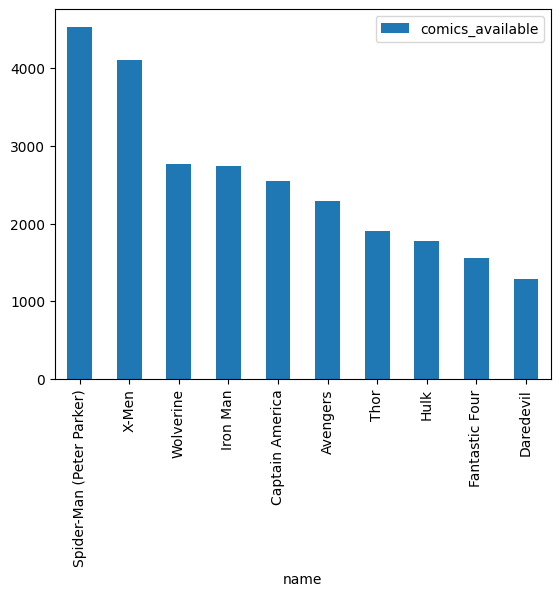

In [106]:
df5.plot.bar(x='name', y='comics_available')

## INSIGHT 5 Characters - Personagens que tem descrição, são personagens mais populares

In [ ]:
df6

## INSIGHT 1 Events - Os 10 eventos com mais histórias em quadrinhos

In [ ]:
df7.plot.bar(x='title', y='comics_available')

## INSIGHT 2 Events - Os eventos com maior duração

In [ ]:
df8

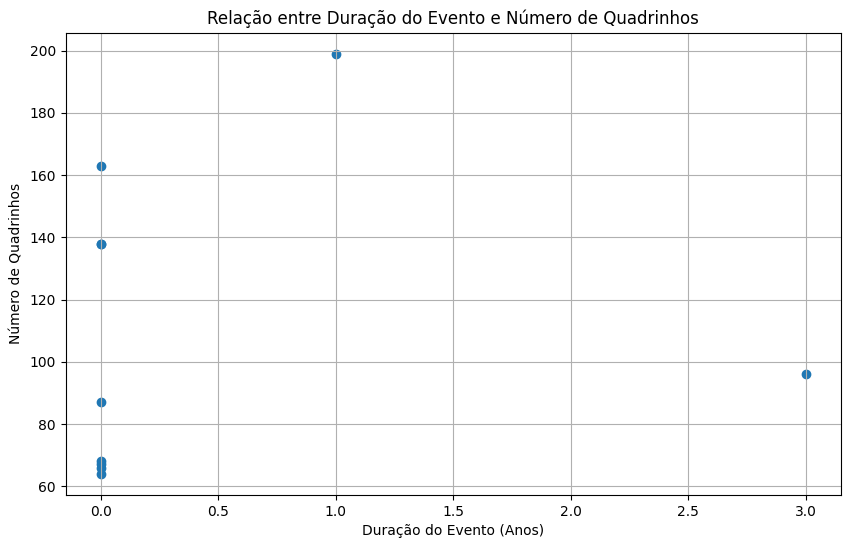

In [108]:
df_merged = pd.merge(df8, df7, on='title', how='inner', suffixes=('_duration', '_comics'))

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['duration_in_years'], df_merged['comics_available_comics'])
plt.xlabel('Duração do Evento (Anos)')
plt.ylabel('Número de Quadrinhos')
plt.title('Relação entre Duração do Evento e Número de Quadrinhos')
plt.grid(True)
plt.show()